## Step 3: Model Training & Evaluation

#### Name: Tian Lan

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import joblib

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_val_score
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### Read data

In [2]:
num_df = pd.read_csv('numeric_data.csv')

In [3]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45077 entries, 0 to 45076
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Followers           45077 non-null  int64  
 1   Total Videos        45077 non-null  int64  
 2   Upload Year         45077 non-null  int64  
 3   Upload Month        45077 non-null  int64  
 4   Upload Day          45077 non-null  int64  
 5   Upload Weekday      45077 non-null  int64  
 6   Engagement Rate     45077 non-null  float64
 7   Number of Hashtags  45077 non-null  int64  
 8   Upload_Afternoon    45077 non-null  int64  
 9   Upload_Evening      45077 non-null  int64  
 10  Upload_Midnight     45077 non-null  int64  
 11  Upload_Morning      45077 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 4.1 MB


In [4]:
num_df.shape

(45077, 12)

In [5]:
num_df.sample(5)

,Followers,Total Videos,Upload Year,Upload Month,Upload Day,Upload Weekday,Engagement Rate,Number of Hashtags,Upload_Afternoon,Upload_Evening,Upload_Midnight,Upload_Morning
30911,909100,200,2020,10,29,4,0.048420,2,1,0,0,0
11491,35100,567,2020,11,1,7,0.022023,3,0,0,0,1
29331,769000,1556,2020,9,23,3,0.065971,1,1,0,0,0
14247,833100,121,2020,8,20,4,0.022592,3,1,0,0,0
3612,21500000,1424,2020,11,2,1,0.046961,0,0,0,1,0


### Split Train, Validation and Test dataset

In [6]:
X = num_df.drop('Engagement Rate', axis=1)
y = num_df['Engagement Rate']

In [7]:
X.shape

(45077, 11)

In [8]:
y.shape

(45077,)

In [9]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=True)

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=42, shuffle=True)

In [11]:
print(f'Shape of X_test set: {X_test.shape}')
print(f'Shape of y_test set: {y_test.shape}')

print(f'Shape of X_validation set: {X_validation.shape}')
print(f'Shape of y_validation set: {y_validation.shape}')

print(f'Shape of X_train set: {X_train.shape}')
print(f'Shape of y_train set: {y_train.shape}')

Shape of X_test set: (13524, 11)
Shape of y_test set: (13524,)
Shape of X_validation set: (9466, 11)
Shape of y_validation set: (9466,)
Shape of X_train set: (22087, 11)
Shape of y_train set: (22087,)


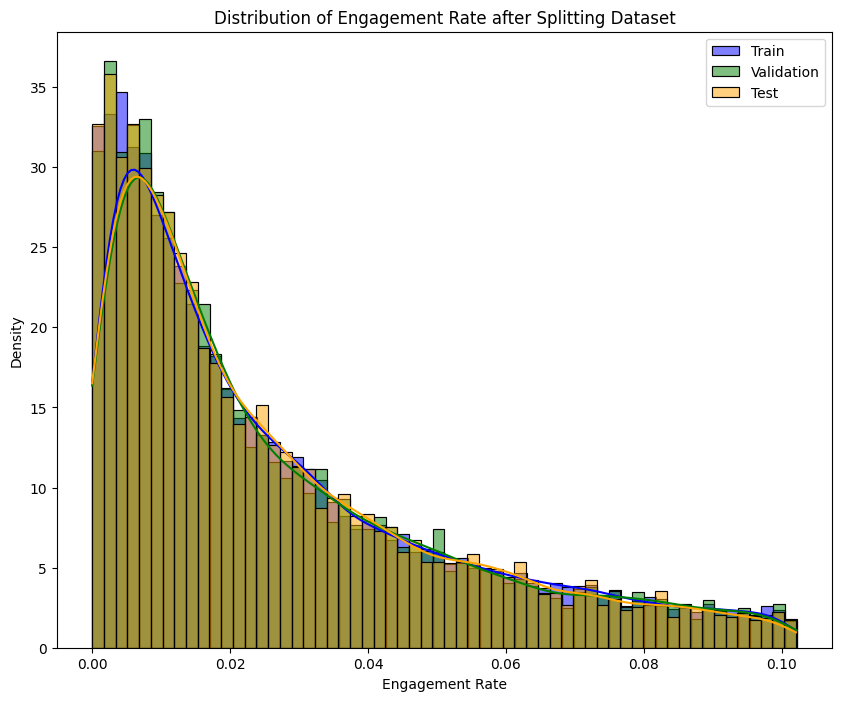

In [12]:
plt.figure(figsize=(10, 8))

# Plot distribution for y_train in blue color
sns.histplot(y_train, bins=60, color='blue', kde=True, label='Train', stat='density')

# Plot distribution for y_validation in orange color
sns.histplot(y_validation, bins=60, color='green', kde=True, label='Validation', stat='density')

# Plot distribution for y_test in orange color
sns.histplot(y_test, bins=60, color='orange', kde=True, label='Test', stat='density')

plt.title('Distribution of Engagement Rate after Splitting Dataset')
plt.xlabel('Engagement Rate')
plt.ylabel('Density')

plt.legend()

plt.show()

### Model Training

#### Linear Regression Model - Baseline Model

In [13]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

In [14]:
y_train_pred = lin_reg.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance before tuning:")
print(f"R-squared: {train_r2}")

Train Set Performance before tuning:
R-squared: 0.09256347753312233


In [15]:
y_test_pred = lin_reg.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance before tuning:")
print(f"R-squared: {test_r2}")

Test Set Performance before tuning:
R-squared: 0.09665017589273694


Upon analyzing the data, it becomes evident that the R-squared value for the linear regression model is merely ~0.09. This value suggests that the independent variables present in the dataframe have limited explanatory power for the dependent variable, which, in this case, is the Engagement rate. Despite any statistical significance of individual variables, the overall linear relationship between the independent variables and the Engagement rate is not pronounced.

Consequently, it is evident that alternative approaches need to be explored, as the current linear regression model does not adequately capture the complexities of the data. We should consider employing non-linear regression models to achieve a better fit and representation of the underlying patterns within the data. Non-linear regression techniques can effectively account for more intricate relationships between variables, thus providing a more accurate and comprehensive understanding of the factors influencing the Engagement rate.

Based on extensive research and prior analysis on numerical prediction models for social media engagement rate, the following models have been identified as promising candidates for fitting non-linear regression between features:
<br>
1. Random Forest Regressor:<br>
The Random Forest regressor is chosen due to its ability to handle high-dimensional datasets and non-linear relationships effectively. By aggregating predictions from multiple decision trees, this ensemble model reduces the risk of overfitting, leading to improved generalization performance and increased robustness against noisy data.<br>
<br>
2. Gradient Boosting Regressor:<br>
The Gradient Boosting regressor is selected for its powerful predictive capabilities, particularly in situations where the data exhibits complex patterns and interactions. Through iterative training and the boosting mechanism, this model sequentially corrects the errors of previous models, eventually converging to a strong predictive function. Consequently, it can capture intricate relationships within the engagement rate data and provide accurate forecasts.<br>
<br>
3. XGBoost Regressor:<br>
XGBoost (Extreme Gradient Boosting) regression is favored for its state-of-the-art performance in various machine learning competitions and applications. Similar to Gradient Boosting, XGBoost employs a boosting approach, but with added regularization techniques to further enhance its accuracy and prevent overfitting. This makes it a suitable choice for the prediction of social media engagement rates, where feature interactions and non-linearities play a significant role.<br>
<br>
4. LightGBM Regressor:<br>
LightGBM is another gradient boosting framework that stands out for its computational efficiency and scalability. By implementing a histogram-based algorithm for binning features, LightGBM reduces memory consumption and speeds up the training process, making it ideal for handling large datasets and quick experimentation with hyperparameters.
<br>

The training and hyperparameter tuning process for each model will adhere to the following sequential steps:

1. Model training on training dataset
2. Hyperparameter tuning on validation dataset
3. Train the best model on the combined training and validation datasets
4. Evaluation of best model on test dataset

*Note:* In light of computational constraints and limited computer configuration, a judicious selection of the most significant hyperparameters for refinement is imperative. Consequently, I will focus on extracting values that encompass a broad range, ensuring comprehensive coverage without excessively burdening the computational resources. A comprehensive loop over all hyperparameters with every conceivable value would be excessively time-consuming and impractical under the given limitations.

#### Random Forest Regressor

In [16]:
# Step 1: Train the model on the training dataset - baseline model

rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance before tuning:")
print(f"R-squared: {train_r2}")

Train Set Performance before tuning:
R-squared: 0.8945520391126001


In [18]:
y_test_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance before tuning:")
print(f"R-squared: {test_r2}")

Test Set Performance before tuning:
R-squared: 0.38724154852055737


Such a large difference between the R-squared values on the train and test sets is a clear sign of **overfitting**. It suggests that the random forest model might become too complex and is capturing noise or idiosyncrasies specific to the training data, making it less effective at generalizing to new, unseen data.

In [19]:
# Step 2: Perform hyperparameter tuning on the validation dataset

param_grid = {
    'n_estimators': np.arange(50, 401, 50),
    'max_depth': np.arange(10, 31, 2),
    'min_samples_split': np.arange(3, 11, 1),
    'min_samples_leaf': np.arange(3, 11, 1),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

**Hyperparameters in Random Forest Regressor:**

1. n_estimators: This parameter represents the number of decision trees in the random forest. It controls how many trees are used in the ensemble and generally a higher number can improve the model's performance but also increase computation time. Increasing the number of estimators can also reduce overfitting, as it helps the model to better generalize by combining predictions from multiple trees.<br>
<br>
2. max_features: It determines the maximum number of features each tree is allowed to use when splitting a node. Using fewer features per split can help reduce variance and potential overfitting, as the model considers a more diverse set of features for each tree. 'sqrt' means the square root of the total number of features, and 'log2' means the logarithm base 2 of the total number of features.<br>
<br>
3. max_depth: This parameter sets the maximum depth of the individual decision trees in the random forest.  Increasing the maximum depth allows the trees to capture more complex relationships in the data, potentially improving model performance.However, deeper trees can lead to overfitting, as the model may memorize noise in the training data. Restricting the maximum depth can help prevent overfitting and promote generalization.<br>
<br>
4. min_samples_split: It defines the minimum number of samples required to split an internal node during tree building. A higher value can prevent overfitting by enforcing more samples in each split.<br>
<br>
5. min_samples_leaf: This parameter sets the minimum number of samples required to be at a leaf node. Larger values can lead to simpler trees and smoother decision boundaries, which can help reduce overfitting and improve model performance on test data.<br>
<br>
6. bootstrap: Bootstrap sampling introduces randomness, leading to more diverse trees and potentially better model performance. Setting bootstrap=True can help reduce overfitting by introducing randomness and diversity in the trees. However, setting bootstrap=False can lead to overfitting if the same data is repeatedly used to build each tree.

In [20]:
grid_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=123,
    n_jobs=-1
)

grid_search_rf.fit(X_validation, y_validation)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400])},
                   random_state=123, scoring='r2')

In [21]:
best_rf_params = grid_search_rf.best_params_

best_rf_model = grid_search_rf.best_estimator_

In [22]:
best_rf_model

RandomForestRegressor(max_depth=28, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=350)

In [23]:
best_rf_params

{'n_estimators': 350,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 28,
 'bootstrap': True}

In [24]:
# Step 3: Train the best model on the combined training and validation datasets (remainder dataset)

best_rf_model.fit(X_remainder, y_remainder)

RandomForestRegressor(max_depth=28, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=350)

In [25]:
# Step 4: Evaluate the performance on the test dataset

In [26]:
y_train_pred = best_rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance:")
print(f"R-squared: {train_r2}")

Train Set Performance:
R-squared: 0.6277678619840009


In [27]:
y_val_pred = best_rf_model.predict(X_validation)
val_r2 = r2_score(y_validation, y_val_pred)

print("Validation Set Performance:")
print(f"R-squared: {val_r2}")

Validation Set Performance:
R-squared: 0.6312364083890665


In [28]:
y_test_pred = best_rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance:")
print(f"R-squared: {test_r2}")

Test Set Performance:
R-squared: 0.34139567753715416


In [29]:
print(f"Best hyperparameters for Random Forest Regressor Model:\n {best_rf_params}")

Best hyperparameters for Random Forest Regressor Model:
 {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 28, 'bootstrap': True}


In [30]:
best_rf_model

RandomForestRegressor(max_depth=28, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=350)

#### Gradient Boosting Regressor

In [31]:
# Step 1: Train the model on the training dataset - baseline model

gb_model = GradientBoostingRegressor()

gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [32]:
y_train_pred = gb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance before tuning:")
print(f"R-squared: {train_r2}")

Train Set Performance before tuning:
R-squared: 0.22586453318777844


In [33]:
y_test_pred = gb_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance before tuning:")
print(f"R-squared: {test_r2}")

Test Set Performance before tuning:
R-squared: 0.21709467057803467


The R-squared values for both the training and testing datasets are comparably low and closely aligned, indicating that the model inadequately captures the variance in the target variable. This observation suggests that the model is exhibiting **underfitting** tendencies prior to hyperparameter tuning.

In [34]:
# Step 2: Perform hyperparameter tuning on the validation dataset

param_grid = {
    'n_estimators': np.arange(50, 401, 50),
    'learning_rate': np.arange(0.01, 0.31, 0.02),
    'max_depth': np.arange(10, 31, 2),
    'min_samples_split': np.arange(3, 11, 1),
    'min_samples_leaf': np.arange(3, 11, 1),
    'subsample': np.arange(0.4, 1.01, 0.1)
}

**Hyperparameters in Gradient Boosting Regressor:**

1. n_estimators: This parameter specifies the number of boosting stages or decision trees to be built. Increasing the number of estimators usually improves the model performance, as it allows the model to capture more complex relationships in the data and reduce bias. However, there is a point of diminishing returns where adding more estimators might not lead to significant improvement. Larger values can lead to overfitting if not controlled properly, especially if the learning rate is high. On the other hand, too few estimators can lead to underfitting, as the model may not have enough capacity to capture complex patterns in the data.<br>
<br>
2. learning_rate: The learning rate controls the step size at each iteration while moving towards a minimum of the loss function. A smaller learning rate makes the model more robust and helps to avoid overshooting the optimal solution. However, it requires more estimators to achieve the same level of performance as a higher learning rate. A high learning rate can lead to overfitting, as it allows the model to quickly fit the training data, potentially ignoring some useful patterns.<br>
<br>
3. max_depth: This parameter sets the maximum depth of the individual decision trees in the ensemble. Increasing this value allows the trees to be more complex, capturing finer details of the data. However, higher values can lead to overfitting, especially if the dataset is small or noisy.<br>
<br>
4. min_samples_split: It determines the minimum number of samples required to split an internal node during tree building. Increasing this value makes the model more conservative, as it prevents the algorithm from creating very specific splits that might only be relevant to the training data. A higher value may lead to simpler trees and reduce the risk of overfitting, but too high a value could also result in underfitting if the model becomes too simplistic.<br>
<br>
5. min_samples_leaf: This parameter sets the minimum number of samples required to be at a leaf node. Similar to min_samples_split, it can influence model complexity and the risk of overfitting or underfitting. Larger values promote simpler trees and may help to prevent overfitting.<br>
<br>
6. subsample: This parameter sets the fraction of samples used for fitting the individual trees. Using a value less than 1.0 introduces randomness and variance into the model, which can help to prevent overfitting and improve generalization. A subsample value that is too close to 1.0 may lead to overfitting, as the model will use almost the entire dataset for building trees. Using a smaller subsample can help reduce overfitting risk but might increase underfitting if the value is too low.

In [35]:
grid_search_gb = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=123,
    n_jobs=-1
)

grid_search_gb.fit(X_validation, y_validation)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29]),
                                        'max_depth': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                                        'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400]),
                                        'subsample': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=123, scoring='r2')

In [36]:
best_gb_params = grid_search_gb.best_params_

best_gb_model = grid_search_gb.best_estimator_

In [37]:
best_gb_params

{'subsample': 0.7,
 'n_estimators': 150,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_depth': 10,
 'learning_rate': 0.03}

In [38]:
best_gb_model

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=5,
                          min_samples_split=3, n_estimators=150, subsample=0.7)

In [39]:
# Step 3: Train the best model on the combined training and validation datasets (remainder dataset)

best_gb_model.fit(X_remainder, y_remainder)

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=5,
                          min_samples_split=3, n_estimators=150, subsample=0.7)

In [40]:
# Step 4: Evaluate the performance on the test dataset

In [41]:
y_train_pred = best_gb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance:")
print(f"R-squared: {train_r2}")

Train Set Performance:
R-squared: 0.5672582552945614


In [42]:
y_val_pred = best_gb_model.predict(X_validation)
val_r2 = r2_score(y_validation, y_val_pred)

print("Validation Set Performance:")
print(f"R-squared: {val_r2}")

Validation Set Performance:
R-squared: 0.5764940452308009


In [43]:
y_test_pred = best_gb_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance:")
print(f"R-squared: {test_r2}")

Test Set Performance:
R-squared: 0.41877185305343756


In [44]:
print(f"Best hyperparameters for Gradient Boosting Regressor Model:\n {best_gb_params}")

Best hyperparameters for Gradient Boosting Regressor Model:
 {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 10, 'learning_rate': 0.03}


In [45]:
best_gb_model

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=5,
                          min_samples_split=3, n_estimators=150, subsample=0.7)

#### XGBoost Regressor Model

In [46]:
# Step 1: Train the model on the training dataset - baseline model

xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
y_train_pred = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance before tuning:")
print(f"R-squared: {train_r2}")

Train Set Performance before tuning:
R-squared: 0.5458225668184105


In [48]:
y_test_pred = xgb_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance before tuning:")
print(f"R-squared: {test_r2}")

Test Set Performance before tuning:
R-squared: 0.37953031278821836


The initial baseline model demonstrates moderate performance prior to undergoing any hyperparameter tuning. I will conduct grid search to identify optimal hyperparameters, with the goal of significantly improving the overall model performance.

In [49]:
param_grid = {
    'n_estimators': np.arange(50, 401, 50),
    'learning_rate': np.arange(0.01, 0.31, 0.02),
    'max_depth': np.arange(10, 31, 2),
    'min_samples_split': np.arange(3, 11, 1),
    'min_samples_leaf': np.arange(3, 11, 1),
    'subsample': np.arange(0.4, 1.01, 0.1)
}

In [50]:
# Step 2: Perform hyperparameter tuning on the validation dataset

param_grid = {
    'booster': ['gbtree', 'dart'],
    'n_estimators': np.arange(50, 401, 50),
    'learning_rate': np.arange(0.01, 0.31, 0.02),
    'max_depth': np.arange(10, 31, 2),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.arange(0, 0.4, 0.1),
    'subsample': np.arange(0.4, 1.01, 0.1),
    'colsample_bytree': np.arange(0.4, 1.01, 0.1),
    'reg_alpha': np.arange(0, 1.01, 0.2),
    'reg_lambda': np.arange(0, 1.01, 0.2)
}

**Hyperparameters in XGBoost Regressor:**

1. n_estimators: This parameter represents the number of boosting rounds or decision trees to be built. Increasing the number of estimators can enhance model performance by capturing more complex patterns in the data. However, a higher value might also increase the risk of overfitting if not balanced properly.<br>
<br>
2. learning_rate: The learning rate determines the step size at each iteration while moving towards a minimum of the loss function. A lower learning rate requires more boosting rounds (n_estimators) to achieve the same performance but can improve generalization and reduce the risk of overfitting.<br>
<br>
3. max_depth: This parameter sets the maximum depth of the individual decision trees in the ensemble. Deeper trees can capture more intricate relationships in the data but may also increase the risk of overfitting, especially if not balanced with other hyperparameters.<br>
<br>
4. subsample: It defines the fraction of samples used for training each tree. A value less than 1.0 introduces randomness by using a subset of the data, which can help prevent overfitting and improve generalization. Values close to 1.0 can lead to overfitting, especially with small datasets.<br>
<br>
5. colsample_bytree: This parameter specifies the fraction of features used for training each tree. Similar to subsample, it introduces randomness and can aid in reducing overfitting. A value of 1.0 uses all features, while a value less than 1.0 uses a subset of features.<br>
<br>
6. booster: The type of booster to use. The choice of booster can significantly impact model performance. 'gbtree' is the traditional boosting method, while 'dart' adds dropout regularization to improve generalization and reduce overfitting. 'dart' can help reduce overfitting compared to 'gbtree' due to the dropout regularization, but it might require more boosting rounds to achieve the same level of performance.<br>
<br>
7. min_child_weight: The minimum sum of instance weight needed in a child. Controls the minimum number of instances required in a child node. Increasing this value can add regularization and make the algorithm more conservative, preventing it from creating child nodes with very few instances. Smaller values of min_child_weight can lead to overfitting since the algorithm might create child nodes with very few instances, tailoring to the noise in the training data. Larger values can lead to underfitting, as the model may not be able to create informative splits.<br>
<br>
8. gamma: The minimum loss reduction required to make a further partition on a leaf node. Increasing this value adds regularization by requiring a higher loss reduction to create new splits, making the model more conservative. Larger values of gamma can help prevent overfitting by avoiding splits that do not significantly improve the model's performance. However, if set too high, it can lead to underfitting as the model might not create enough splits.<br>
<br>
9. reg_alpha: L1 regularization term on weights (Lasso regularization).Adding reg_alpha introduces L1 regularization to the model, which can help reduce the impact of less important features and prevent overfitting. A positive reg_alpha value can help prevent overfitting, but if set too high, it might lead to underfitting, as the model could excessively penalize feature weights.<br>
<br>
10. reg_lambda: L2 regularization term on weights (Ridge regularization). Adding reg_lambda introduces L2 regularization to the model, which can help prevent overfitting by penalizing large weights. Similar to reg_alpha, a positive reg_lambda value can help prevent overfitting, but if set too high, it might lead to underfitting.<br>
<br>

In [51]:
grid_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=123,
    n_jobs=-1,
)

grid_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29]),
                                        'max_depth': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400]),
                                        'reg_alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'reg_lambda': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'subsample': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=123, scoring='r2')

In [52]:
best_xgb_params = grid_search_xgb.best_params_

best_xgb_model = grid_search_xgb.best_estimator_

In [53]:
# Step 3: Train the best model on the combined training and validation datasets (remainder dataset)

best_xgb_model.fit(X_remainder, y_remainder)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16999999999999998,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
# Step 4: Evaluate the performance on the test dataset

In [55]:
y_train_pred = best_xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance:")
print(f"R-squared: {train_r2}")

Train Set Performance:
R-squared: 0.686563972086681


In [56]:
y_val_pred = best_xgb_model.predict(X_validation)
val_r2 = r2_score(y_validation, y_val_pred)

print("Validation Set Performance:")
print(f"R-squared: {val_r2}")

Validation Set Performance:
R-squared: 0.6900807299528331


In [57]:
y_test_pred = best_xgb_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance:")
print(f"R-squared: {test_r2}")

Test Set Performance:
R-squared: 0.4408940187950765


In [58]:
print(f"Best hyperparameters for XGBoost Regressor Model:\n {best_xgb_params}")

Best hyperparameters for XGBoost Regressor Model:
 {'subsample': 0.9999999999999999, 'reg_lambda': 0.2, 'reg_alpha': 0.2, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 30, 'learning_rate': 0.16999999999999998, 'gamma': 0.0, 'colsample_bytree': 0.7, 'booster': 'dart'}


In [59]:
best_xgb_model

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16999999999999998,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### LightGBM Regressor

In [60]:
# Step 1: Train the model on the training dataset - baseline model

lgbm_model = lgb.LGBMRegressor(verbose=-1)

lgbm_model.fit(X_train, y_train)

LGBMRegressor(verbose=-1)

In [61]:
y_train_pred = lgbm_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance before tuning:")
print(f"R-squared: {train_r2}")

Train Set Performance before tuning:
R-squared: 0.3709392489875082


In [62]:
y_test_pred = lgbm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance before tuning:")
print(f"R-squared: {test_r2}")

Test Set Performance before tuning:
R-squared: 0.3091900054702652


The R-squared values on both the training and testing datasets are relatively low, indicating that the model cannot be deemed well-established. The limited R-squared values suggest that the model's ability to explain the dataset's variance is not substantial.

In [63]:
# Step 2: Perform hyperparameter tuning on the validation dataset

param_grid = {
    'n_estimators': np.arange(50, 401, 50),
    'learning_rate': np.arange(0.01, 0.31, 0.02),
    'max_depth': np.arange(10, 31, 2),
    'num_leaves': np.arange(10, 101, 10),
    'min_child_samples': np.arange(5, 31, 1),
    'subsample': np.arange(0.4, 1.01, 0.1),
    'colsample_bytree': np.arange(0.4, 1.01, 0.1),
    'reg_alpha': np.arange(0, 1.01, 0.2),
    'reg_lambda': np.arange(0, 1.01, 0.2),
    'min_split_gain': np.arange(0, 1.01, 0.2),
    'verbose': [-1] # suppress warning messages from LightGBM
}

**Hyperparameters in LightGBM Regressor:**

1. num_leaves: This parameter represents the maximum number of leaves or terminal nodes in a tree. A higher value can lead to a more complex model with better capacity to capture intricate patterns in the data. However, an excessively high value might risk overfitting, especially with small datasets.<br>
<br>
2. learning_rate: The learning rate determines the step size at each iteration while moving towards a minimum of the loss function. A lower learning rate requires more boosting rounds (n_estimators) to achieve the same performance but can improve generalization and reduce the risk of overfitting.<br>
<br>
3. max_depth: This parameter sets the maximum depth of the individual decision trees in the ensemble. Deeper trees can capture more complex relationships in the data, but they may also increase the risk of overfitting, especially if not balanced with other hyperparameters.<br>
<br>
4. n_estimators: This parameter specifies the number of boosting rounds or decision trees to be built. Increasing the number of estimators can improve model performance by capturing more complex patterns in the data. However, a higher value might also increase the risk of overfitting if not balanced properly.<br>
<br>
5. subsample: It defines the fraction of samples used for training each tree. A value less than 1.0 introduces randomness by using a subset of the data, which can help prevent overfitting and improve generalization. Values close to 1.0 can lead to overfitting, especially with small datasets.<br>
<br>
6. colsample_bytree: This parameter specifies the fraction of features used for training each tree. Similar to subsample, it introduces randomness and can aid in reducing overfitting. A value of 1.0 uses all features, while a value less than 1.0 uses a subset of features.<br>
<br>
7. verbose: The verbose parameter is not directly related to model performance but controls the amount of output messages printed during the training process. By setting it to -1, warning messages from LightGBM will be suppressed.<br>
<br>
8. min_child_samples: The minimum number of data points needed in a child node. Increasing this value adds regularization and makes the algorithm more conservative, preventing it from creating child nodes with very few instances. Smaller values of min_child_samples can lead to overfitting since the algorithm might create child nodes with very few instances, tailoring to the noise in the training data. Larger values can lead to underfitting, as the model may not be able to create informative splits.<br>
<br>
9. reg_alpha: L1 regularization term on weights (Lasso regularization).Adding reg_alpha introduces L1 regularization to the model, which can help reduce the impact of less important features and prevent overfitting. A positive reg_alpha value can help prevent overfitting, but if set too high, it might lead to underfitting, as the model could excessively penalize feature weights.<br>
<br>
10. reg_lambda: L2 regularization term on weights (Ridge regularization). Adding reg_lambda introduces L2 regularization to the model, which can help prevent overfitting by penalizing large weights. Similar to reg_alpha, a positive reg_lambda value can help prevent overfitting, but if set too high, it might lead to underfitting.<br>
<br>
11. min_split_gain: The minimum loss reduction required to make a further partition on a leaf node. Increasing this value adds regularization by requiring a higher loss reduction to create new splits, making the model more conservative. Larger values of min_split_gain can help prevent overfitting by avoiding splits that do not significantly improve the model's performance. However, if set too high, it can lead to underfitting as the model might not create enough splits.

In [64]:
grid_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=123,
    n_jobs=-1,
)

grid_search_lgbm.fit(X_validation, y_validation)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(verbose=-1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29]),
                                        'max_depth': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                                        'min_child_samples': array([ 5,  6,  7,  8,  9, 10...
       22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_split_gain': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400]),
                                        'num_leaves': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'reg_alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'reg_lambda': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'subsample': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'verbose': [-1]},
                   random_state=123, scoring='r2')

In [65]:
best_lgbm_params = grid_search_lgbm.best_params_

best_lgbm_model = grid_search_lgbm.best_estimator_

In [66]:
# Step 3: Train the best model on the combined training and validation datasets (remainder dataset)

best_lgbm_model.fit(X_remainder, y_remainder)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.06999999999999999,
              max_depth=24, min_child_samples=18, n_estimators=150,
              num_leaves=40, reg_lambda=1.0, subsample=0.6, verbose=-1)

In [67]:
# Step 4: Evaluate the performance on the test dataset

In [68]:
y_train_pred = best_lgbm_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Train Set Performance:")
print(f"R-squared: {train_r2}")

Train Set Performance:
R-squared: 0.3898382033429123


In [69]:
y_val_pred = best_lgbm_model.predict(X_validation)
val_mse = mean_squared_error(y_validation, y_val_pred)
val_r2 = r2_score(y_validation, y_val_pred)

print("Validation Set Performance:")
print(f"R-squared: {val_r2}")

Validation Set Performance:
R-squared: 0.4051632079169408


In [70]:
y_test_pred = best_lgbm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance:")
print(f"R-squared: {test_r2}")

Test Set Performance:
R-squared: 0.336126903637019


In [71]:
print(f"Best hyperparameters for LightGBM Regressor Model:\n {best_lgbm_params}")

Best hyperparameters for LightGBM Regressor Model:
 {'verbose': -1, 'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'num_leaves': 40, 'n_estimators': 150, 'min_split_gain': 0.0, 'min_child_samples': 18, 'max_depth': 24, 'learning_rate': 0.06999999999999999, 'colsample_bytree': 0.7}


In [72]:
best_lgbm_model

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.06999999999999999,
              max_depth=24, min_child_samples=18, n_estimators=150,
              num_leaves=40, reg_lambda=1.0, subsample=0.6, verbose=-1)

### Model Evaluation

Having concluded the hyperparameter tuning process, I now possess a collection of optimized models. The next step involves evaluating these models to determine the one that demonstrates superior performance and is most suitable for this prediction task.

In this evaluation, I will use k-fold cross-validation on train data and calculate regression metrics on test data to assess the performance of each model. By employing appropriate metrics, I can objectively compare and contrast the predictive capabilities of the models, aiding in the identification of the optimal candidate for deployment in real-world scenarios.

In [73]:
best_rf_model

RandomForestRegressor(max_depth=28, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=350)

In [74]:
best_gb_model

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=5,
                          min_samples_split=3, n_estimators=150, subsample=0.7)

In [75]:
best_xgb_model

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16999999999999998,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [76]:
best_lgbm_model

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.06999999999999999,
              max_depth=24, min_child_samples=18, n_estimators=150,
              num_leaves=40, reg_lambda=1.0, subsample=0.6, verbose=-1)

Cross-validation on the training data provides an estimate of the model's generalization performance, but the final evaluation on the test data gives a more reliable indication of how the model will perform in the real world.

In [77]:
models = {
    'Random Forest Regressor': best_rf_model,
    'Gradient Boosting Regressor': best_gb_model,
    'XGBoost Regressor': best_xgb_model,
    'LightGBM Regressor': best_lgbm_model
}

In [78]:
scoring = 'neg_mean_squared_error'
cv_results = {}

for model_name, model in models.items():
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_remainder, y_remainder, cv=5, scoring=scoring)
    
    cv_results[model_name] = scores

# Calculate the mean and standard deviation of the cross-validation scores for each model
mean_scores = {model_name: -scores.mean() for model_name, scores in cv_results.items()}
std_scores = {model_name: scores.std() for model_name, scores in cv_results.items()}

# Print the mean and standard deviation of cross-validation scores for each model
for model_name, mean_score in mean_scores.items():
    
    std_score = std_scores[model_name]
    
    print(f"{model_name}\n- Mean Cross-Validation Score (i.e. MSE): {mean_score}\n- Standard Deviation: {std_score}")

Random Forest Regressor
- Mean Cross-Validation Score (i.e. MSE): 0.000415616173727864
- Standard Deviation: 7.608863366004595e-06
Gradient Boosting Regressor
- Mean Cross-Validation Score (i.e. MSE): 0.00036633365526262036
- Standard Deviation: 5.6698729176896945e-06
XGBoost Regressor
- Mean Cross-Validation Score (i.e. MSE): 0.00035290210412060796
- Standard Deviation: 5.1892922642678194e-06
LightGBM Regressor
- Mean Cross-Validation Score (i.e. MSE): 0.0004100657687713046
- Standard Deviation: 5.065507598700584e-06


The **XGBoost Regressor** demonstrates superior performance with the lowest Mean Squared Error (MSE) and low variability across different folds. Its predictions are closer to the actual values, ensuring stability and consistent results compared to other models analyzed. Thus, the **XGBoost Regressor** stands out as the top choice.

In [79]:
print("Model Performance on Test Set:")

# Random Forest
y_test_pred_rf = best_rf_model.predict(X_test)

rf_mse = metrics.mean_squared_error(y_test, y_test_pred_rf)
rf_rmse = metrics.mean_squared_error(y_test, y_test_pred_rf, squared=False)
rf_mae = metrics.mean_absolute_error(y_test, y_test_pred_rf)
rf_mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred_rf)
rf_r2 = metrics.r2_score(y_test, y_test_pred_rf)
rf_evs = metrics.explained_variance_score(y_test, y_test_pred_rf)

print("\nRandom Forest:")
print(f"Mean Squared Error (MSE): {rf_mse}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse}")
print(f"Mean Absolute Error (MAE): {rf_mae}")
print(f"Mean Absolute Percentage Error (MAPE): {rf_mape}")
print(f"R-squared: {rf_r2}")
print(f"Explained Variance Score: {rf_evs}" )

# Gradient Boosting
y_test_pred_gb = best_gb_model.predict(X_test)

gb_mse = metrics.mean_squared_error(y_test, y_test_pred_gb)
gb_rmse = metrics.mean_squared_error(y_test, y_test_pred_gb, squared=False)
gb_mae = metrics.mean_absolute_error(y_test, y_test_pred_gb)
gb_mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred_gb)
gb_r2 = metrics.r2_score(y_test, y_test_pred_gb)
gb_evs = metrics.explained_variance_score(y_test, y_test_pred_gb)

print("\nGradient Boosting:")
print(f"Mean Squared Error (MSE): {gb_mse}")
print(f"Root Mean Squared Error (RMSE): {gb_rmse}")
print(f"Mean Absolute Error (MAE): {gb_mae}")
print(f"Mean Absolute Percentage Error (MAPE): {gb_mape}")
print(f"R-squared: {gb_r2}")
print(f"Explained Variance Score: {gb_evs}")

# XGBoost
y_test_pred_xgb = best_xgb_model.predict(X_test)
xgb_mse = metrics.mean_squared_error(y_test, y_test_pred_xgb)
xgb_rmse = metrics.mean_squared_error(y_test, y_test_pred_xgb, squared=False)
xgb_mae = metrics.mean_absolute_error(y_test, y_test_pred_xgb)
xgb_mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred_xgb)
xgb_r2 = metrics.r2_score(y_test, y_test_pred_xgb)
xgb_evs = metrics.explained_variance_score(y_test, y_test_pred_xgb)

print("\nXGBoost:")
print(f"Mean Squared Error (MSE): {xgb_mse}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse}")
print(f"Mean Absolute Error (MAE): {xgb_mae}")
print(f"Mean Absolute Percentage Error (MAPE): {xgb_mape}")
print(f"R-squared: {xgb_r2}")
print(f"Explained Variance Score: {xgb_evs}")

# LightGBM
y_test_pred_lgbm = best_lgbm_model.predict(X_test)
lgbm_mse = metrics.mean_squared_error(y_test, y_test_pred_lgbm)
lgbm_rmse = metrics.mean_squared_error(y_test, y_test_pred_lgbm, squared=False)
lgbm_mae = metrics.mean_absolute_error(y_test, y_test_pred_lgbm)
lgbm_mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred_lgbm)
lgbm_r2 = metrics.r2_score(y_test, y_test_pred_lgbm)
lgbm_evs = metrics.explained_variance_score(y_test, y_test_pred_lgbm)

print("\nLightGBM:")
print(f"Mean Squared Error (MSE): {lgbm_mse}")
print(f"Root Mean Squared Error (RMSE): {lgbm_rmse}")
print(f"Mean Absolute Error (MAE): {lgbm_mae}")
print(f"Mean Absolute Percentage Error (MAPE): {lgbm_mape}")
print(f"R-squared: {lgbm_r2}")
print(f"Explained Variance Score: {lgbm_evs}")

Model Performance on Test Set:

Random Forest:
Mean Squared Error (MSE): 0.00038812861298271104
Root Mean Squared Error (RMSE): 0.01970098000056624
Mean Absolute Error (MAE): 0.014896854713453585
Mean Absolute Percentage Error (MAPE): 93200116041.73819
R-squared: 0.34139567753715416
Explained Variance Score: 0.3418094736084407

Gradient Boosting:
Mean Squared Error (MSE): 0.0003425292953700695
Root Mean Squared Error (RMSE): 0.018507546984137837
Mean Absolute Error (MAE): 0.013866415770654424
Mean Absolute Percentage Error (MAPE): 40532692288.61845
R-squared: 0.41877185305343756
Explained Variance Score: 0.4190903593672818

XGBoost:
Mean Squared Error (MSE): 0.0003294922635550219
Root Mean Squared Error (RMSE): 0.018151921759279977
Mean Absolute Error (MAE): 0.013275136834806743
Mean Absolute Percentage Error (MAPE): 42490659051.411194
R-squared: 0.4408940187950765
Explained Variance Score: 0.44120398231661984

LightGBM:
Mean Squared Error (MSE): 0.0003912336061268978
Root Mean Squared

**Mean Squared Error (MSE)**: The Mean Squared Error measures the average squared difference between the predicted values and the actual target values. It quantifies the average prediction error, with lower values indicating better performance.

**Root Mean Squared Error (RMSE)**: The Root Mean Squared Error is the square root of the MSE. It measures the average absolute difference between the predicted values and the actual target values, providing a more interpretable metric in the original units of the target variable. Like MSE, lower values of RMSE indicate better performance.

**Mean Absolute Error (MAE)**: The Mean Absolute Error calculates the average absolute difference between the predicted values and the actual target values. Like MSE and RMSE, lower values of MAE indicate better model performance. MAE is also commonly used in regression tasks and is less sensitive to outliers compared to MSE.

**Mean Absolute Percentage Error(MAPE)**: MAPE measures the percentage difference between the predicted values and the actual target values, averaged across all data points. It is useful for understanding the relative magnitude of the errors in the predictions and is often used to assess the accuracy of models when dealing with different scales of target variables. Similar to other evaluation metrics, lower values of MAPE indicate better model performance, as it represents a smaller percentage of error in the predictions relative to the actual values.

*Note:* It is imperative to consider that the MAPE value can be substantially influenced by the presence of outliers and the overall data distribution within the dataset. In this specific context, the dataset contains influential videos/videos from top TikTok users that exhibit a relatively high engagement rate. As a consequence, the MAPE value may be disproportionately inflated, potentially leading to an inaccurate reflection of the model's performance.

**R-squared (R2)**: R-squared is a statistical measure that represents the proportion of variance in the target variable that is explained by the model. It ranges from 0 to 1, where 1 indicates a perfect fit, and 0 indicates that the model does not explain any variance. R-squared is used to assess how well the model fits the data, with higher values indicating better goodness-of-fit.

**Explained Variance Score**: The Explained Variance Score is another metric that measures the proportion of variance in the target variable that is explained by the model. It is similar to R-squared and ranges from 0 to 1. The Explained Variance Score is slightly different from R-squared in the calculation method, but they are generally similar in terms of interpretation and evaluation.

Based on the evaluation metrics, the **Gradient Boosting Regressor model and XGBoost Regressor model** seems to be the better-performing models on test data among the four. Both of them have the lower values for MSE, RMSE, MAE, and MAPE, and also have the higher values for R-squared and Explained Variance Score.

**Plot learning curves to visualize how well the model is performing and whether it is underfitting or overfitting.**

In [80]:
def plot_learning_curve_subplot(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10), plot_id=1, y_range=None):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='r2', n_jobs=-1)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.subplot(2, 2, plot_id)
    plt.title(title)
    plt.xlabel("Data Size")
    plt.ylabel("R-Squared")
    plt.grid()

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Train")
    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation")

    plt.legend(loc="best")

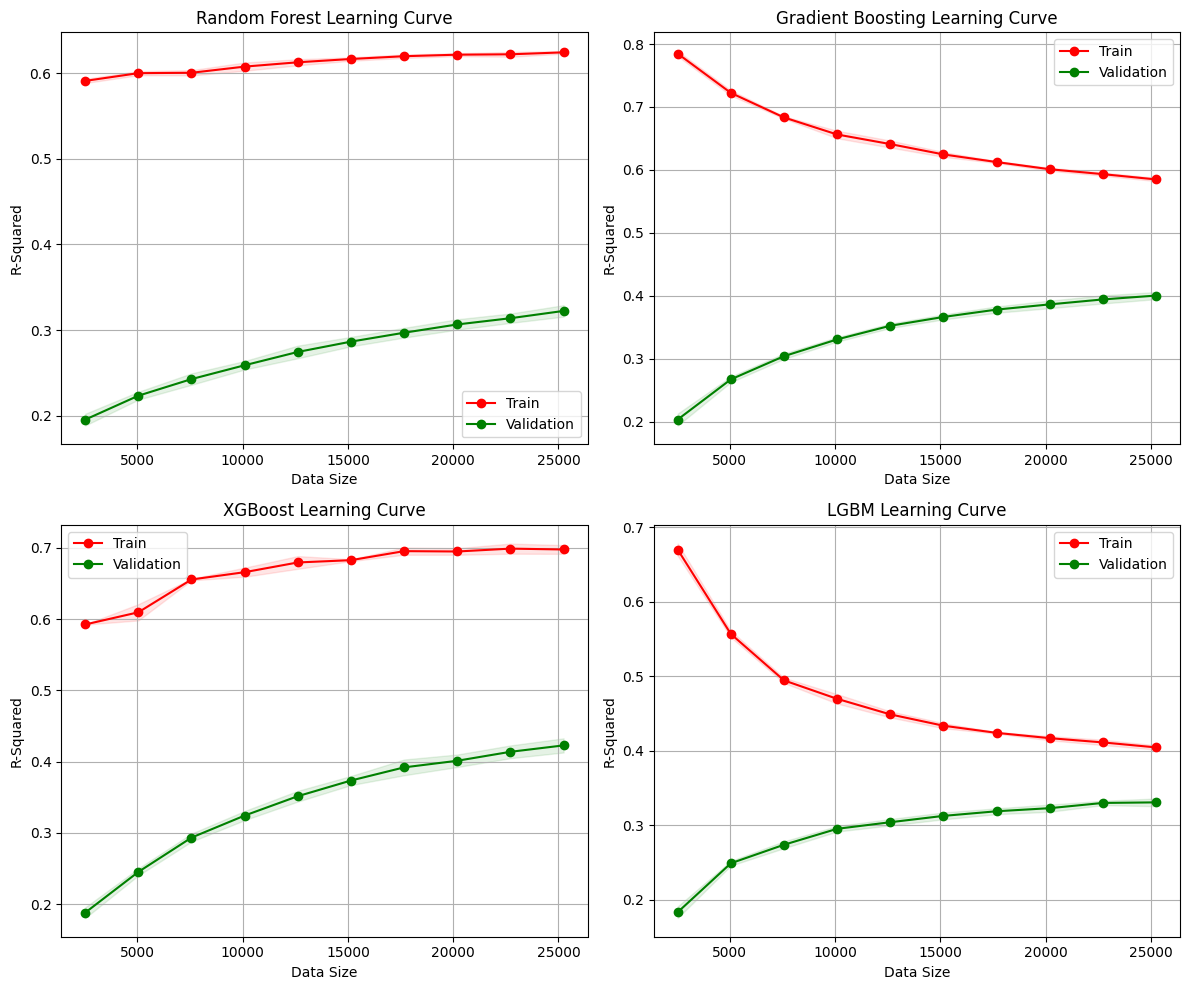

In [81]:
plt.figure(figsize=(12, 10))

# Plot learning curve for Random Forest
plot_learning_curve_subplot(best_rf_model, "Random Forest Learning Curve", X_remainder, y_remainder, cv=5, plot_id=1)

# Plot learning curve for Gradient Boosting
plot_learning_curve_subplot(best_gb_model, "Gradient Boosting Learning Curve", X_remainder, y_remainder, cv=5, plot_id=2)

# Plot learning curve for XGBoost
plot_learning_curve_subplot(best_xgb_model, "XGBoost Learning Curve", X_remainder, y_remainder, cv=5, plot_id=3)

# Plot learning curve for LGBM
plot_learning_curve_subplot(best_lgbm_model, "LGBM Learning Curve", X_remainder, y_remainder, cv=5, plot_id=4)

plt.tight_layout()

plt.savefig('Learning curve.png')

plt.show()

Based on the learning curve analysis, the Random Forest Regressor and XGBoost Regressor demonstrated inferior performance. The R-squared value showed an increasing trend as the data size expanded, with both regressors gradually converging. There was no distinct indication of underfitting or overfitting. These models appeared to struggle in effectively learning from the training data, indicating that further augmentation of the training dataset may not significantly improve their performance.

Conversely, the Gradient Boosting Regressor and LightGBM Regressor exhibited more favorable results. With the addition of extra data, the R-squared value for the training set decreased, while for the validation set, it increased. The models perfectly fit one or two data points, leading to a high R-squared value at the beginning. As the training data size increased, the algorithm faced challenges in perfectly fitting all examples, resulting in a diminished performance on the training set. Proper training of the models enabled a reduction in error with the increase of validation data, leading to an elevation of the R-squared value, ultimately approaching a plateau that represents the model's optimal performance.

Although the gap between the training and validation data was narrower in the LightGBM Regressor, the Gradient Boosting Regressor displayed a higher validation R-squared value. This difference was anticipated considering the high variance nature of the data. Therefore, the focus was on the final R-squared value to evaluate model performance. Consequently, the **Gradient Boosting Regressor** demonstrated the most favorable performance among the evaluated models.

Upon evaluating the model performance on both the training dataset (comprising the combined train and validation data) and the testing dataset, it is evident that the **Gradient Boosting Regressor model** exhibits commendable performance. The model demonstrates consistent efficacy on both datasets, implying a robust and generalizable predictive ability. 

In [82]:
best_model = best_gb_model

best_model

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=5,
                          min_samples_split=3, n_estimators=150, subsample=0.7)

In [83]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']